This notebook examines the posterior of the Bayesian AR detector, where the posterior has been directly calculated on a 3D grid using brute force.

In [1]:
# """ Initialize the notebook """
%matplotlib inline
import pylab as PP
import matplotlib as mpl
import netCDF4 as nc
import glob
import datetime as dt
import collections
import sys
import os
import socket
import dateutil
import pickle
from ARDetector import ARDetector
import warnings
import numpy as np
import IPython
import scipy.integrate
from mpl_toolkits.basemap import Basemap, cm

#Set the default font for plots
font = { 'family' : 'sans-serif', \
         'size' : '15', \
         'weight' : 'bold'}
mpl.rc('font', **font)
mpl.rc('axes', labelweight = 'bold') # needed for bold axis labels in more recent version of matplotlib

# turn off warnings (there are a ton of irrelevant ones in this notebook)
warnings.filterwarnings('ignore')

# print any git repository info too
import git
try:
    _repo = git.Repo(search_parent_directories=True)
    _git_sha = _repo.head.object.hexsha
    _git_short_sha = _repo.git.rev_parse(_git_sha, short=7)
    _git_branch = _repo.active_branch
    print("On branch {} at rev {}".format(_git_branch,_git_short_sha))
except:
    print("No repository detected.")

import os; print("{}:{}".format(socket.gethostname(),os.getcwd()))

On branch master at rev 754b67e
cori19:/global/project/projectdirs/m1517/cascade/taobrien/artmip/tier1/bayesian_ar_detector


In [2]:
with open("likelihood_and_counts_on_grid.pk",'rb') as fin:
    input_dictionary = pickle.load(fin)
    
input_dictionary.print_props()


	git_sha:	754b67e8e4d17c72ed500da204467f8f1418e974
	git_branch:	master
	hostname:	nid00009
	cwd:	/global/project/projectdirs/m1517/cascade/taobrien/artmip/tier1/bayesian_ar_detector
	command:	brute_force_check_log_posterior.py


In [3]:
theta = input_dictionary['theta']
percentile = theta[0,:,0,0]
filter_lat_width = theta[:,0,0,1]
minimum_area = theta[0,0,:,2]

# set axes for the variables
axes = collections.OrderedDict( [('P', 0), (r'$\Delta y$', 1),('$A_{min}$', 2)] )
varnames = list(axes)

values = {}
# extract parameter vectors from the theta cube
for var in axes:
    slice_tuple = [0,0,0,0]
    slice_tuple[axes[var]] = slice(None,None,None)
    slice_tuple[-1] = axes[var]
    values[var] = theta[tuple(slice_tuple)]


In [4]:
log_posterior_3d = input_dictionary['log_posterior']
# integrate the posterior and normalize
posterior = np.exp(log_posterior_3d)

norm = np.array(posterior,copy=True)
for var in list(axes)[::-1]:
    norm = scipy.integrate.simps(norm,x=values[var],axis=-1)
    
posterior /= norm

# calculate weights for doing posterior-weighted averages
dvalues = 1
for var in axes:
    dv = np.diff(values[var])[0]
    dvalues *= dv

posterior_weights = np.ma.masked_equal(posterior*dvalues,0)

In [5]:
""" Calculate the ~max likelihood parameter settings """
theta = np.array(np.meshgrid(*[values[var] for var in axes],indexing='ij'))

imax = np.unravel_index(log_posterior_3d.argmax(),log_posterior_3d.shape)
imax_slice = [slice(None,None,None)] + list(imax)
theta_ml = theta[imax_slice]

print("Maximum likelihood:")
for n,var in enumerate(list(axes)):
    print("\t{} : {:2.3g}".format(varnames[n],theta_ml[n]))

print("\tN_bar : {:2.3g}".format(input_dictionary['avg_counts'][imax]))
print("\tN_min : {:2.3g}".format(input_dictionary['min_counts'][imax]))
print("\tN_max : {:2.3g}".format(input_dictionary['max_counts'][imax]))

Maximum likelihood:
	P : 0.824
	$\Delta y$ : 11.7
	$A_{min}$ : 1.36e+12
	N_bar : 10.5
	N_min :  7
	N_max : 15


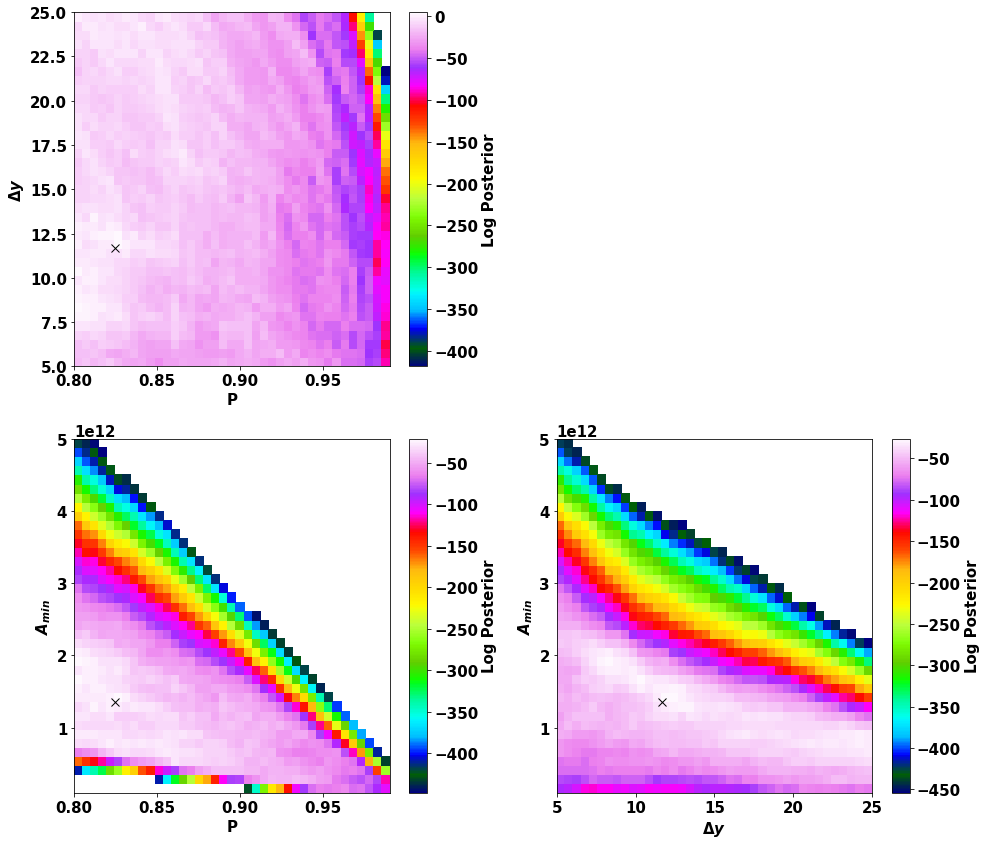

In [6]:
""" Plot the likelihood """
min_count_3d = input_dictionary['min_counts']

fig, axs = PP.subplots(2,2,figsize=(14,12))

axs[0,1].axis('off')
for i in range(len(axes)):
    for j in range(i+1,len(axes)):
        master_list = list(range(len(axes)))
        master_list.pop(j)
        master_list.pop(i)
        remaining_axis = master_list[0]
        
        posterior2d = scipy.integrate.simps(posterior,x=values[varnames[remaining_axis]],axis=axes[varnames[remaining_axis]])
        
        ax = axs[j-1,i]
        cplt = ax.pcolormesh(values[varnames[i]],values[varnames[j]],np.log(posterior2d.T),cmap='gist_ncar')
        
        ax.plot(theta_ml[i],theta_ml[j],'kx',markersize=8)
        
        ax.set_xlabel(varnames[i])
        ax.set_ylabel(varnames[j])
        fig.colorbar(cplt,ax=ax,label='Log Posterior')

PP.tight_layout()
PP.savefig('log_posterior_brute_force.png')
PP.show()
        

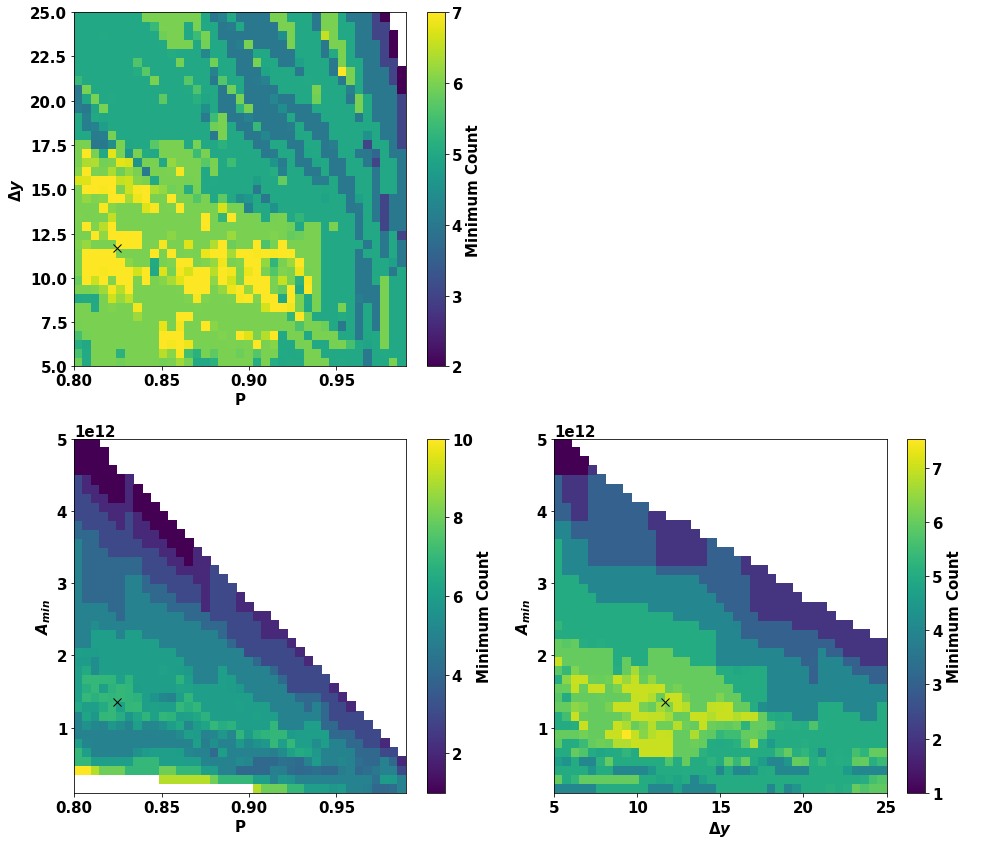

In [7]:
""" Plot minimum counts """
min_count_3d = input_dictionary['min_counts']

fig, axs = PP.subplots(2,2,figsize=(14,12))

axs[0,1].axis('off')
for i in range(len(axes)):
    for j in range(i+1,len(axes)):
        master_list = list(range(len(axes)))
        master_list.pop(j)
        master_list.pop(i)
        remaining_axis = master_list[0]
        
        min_counts_tmp = np.ma.average(min_count_3d,weights=posterior_weights, axis=remaining_axis)
        
        ax = axs[j-1,i]
        cplt = ax.pcolormesh(values[varnames[i]],values[varnames[j]],min_counts_tmp.T)
        
        ax.plot(theta_ml[i],theta_ml[j],'kx',markersize=8)
        
        ax.set_xlabel(varnames[i])
        ax.set_ylabel(varnames[j])
        fig.colorbar(cplt,ax=ax,label='Minimum Count')
    
PP.tight_layout()
PP.show()
        

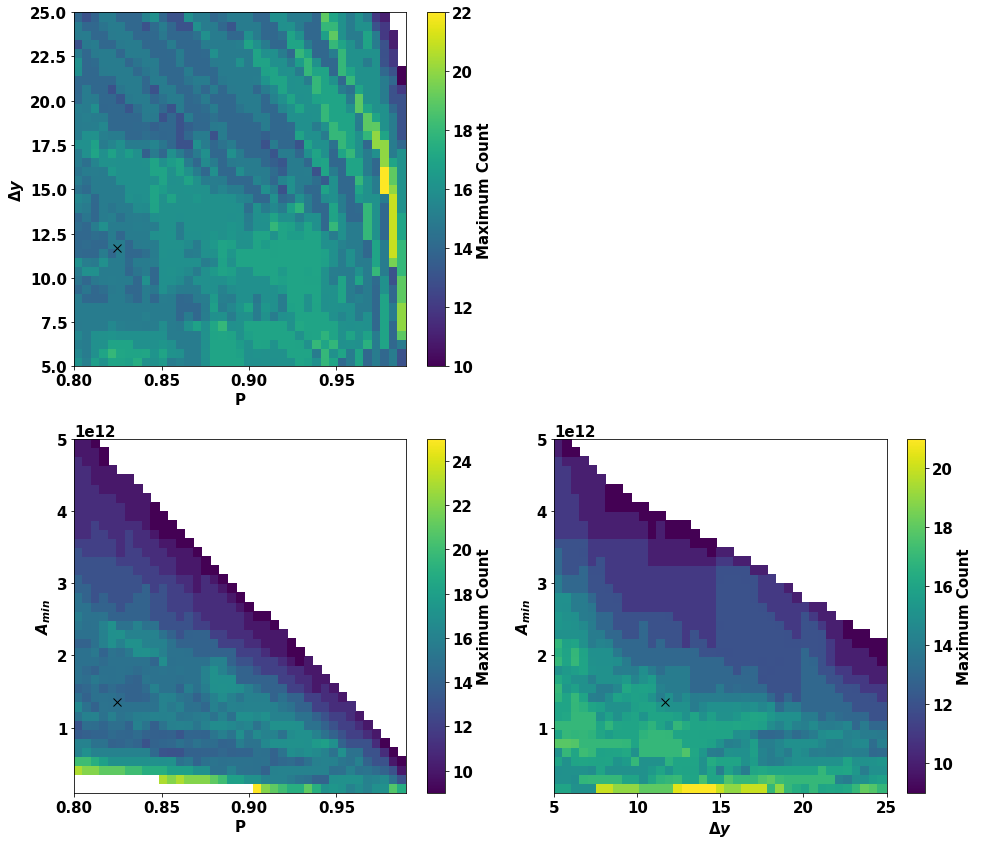

In [8]:
""" Plot maximum counts """
max_count_3d = input_dictionary['max_counts']

fig, axs = PP.subplots(2,2,figsize=(14,12))

axs[0,1].axis('off')
for i in range(len(axes)):
    for j in range(i+1,len(axes)):
        master_list = list(range(len(axes)))
        master_list.pop(j)
        master_list.pop(i)
        remaining_axis = master_list[0]
        
        max_counts_tmp = np.ma.average(max_count_3d,weights=posterior_weights, axis=remaining_axis)
        
        ax = axs[j-1,i]
        cplt = ax.pcolormesh(values[varnames[i]],values[varnames[j]],max_counts_tmp.T)
        
        ax.plot(theta_ml[i],theta_ml[j],'kx',markersize=8)
        
        ax.set_xlabel(varnames[i])
        ax.set_ylabel(varnames[j])
        fig.colorbar(cplt,ax=ax,label='Maximum Count')
    
PP.tight_layout()
PP.show()
        

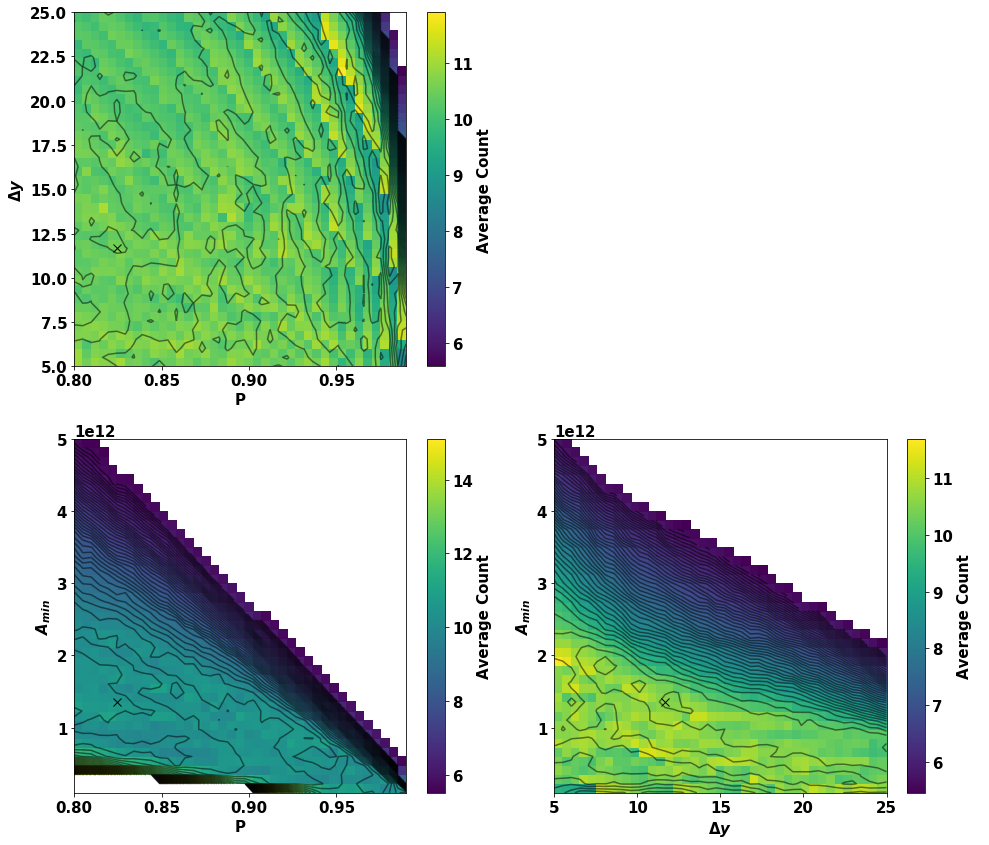

In [9]:
""" Plot average counts """
avg_count_3d = input_dictionary['avg_counts']

fig, axs = PP.subplots(2,2,figsize=(14,12))

axs[0,1].axis('off')
for i in range(len(axes)):
    for j in range(i+1,len(axes)):
        master_list = list(range(len(axes)))
        master_list.pop(j)
        master_list.pop(i)
        remaining_axis = master_list[0]
        
        #avg_counts_tmp = avg_count_3d.mean(axis=remaining_axis)
        
        avg_counts_tmp = np.average(avg_count_3d,weights=posterior_weights,axis=remaining_axis)

        posterior2d = scipy.integrate.simps(posterior,x=values[varnames[remaining_axis]],axis=axes[varnames[remaining_axis]])
        
        ax = axs[j-1,i]
        cplt = ax.pcolormesh(values[varnames[i]],values[varnames[j]],avg_counts_tmp.T)
        ax.contour(values[varnames[i]],values[varnames[j]],-np.log(posterior2d.T),50,colors='k', alpha = 0.5)
        
        ax.plot(theta_ml[i],theta_ml[j],'kx',markersize=8)
        
        ax.set_xlabel(varnames[i])
        ax.set_ylabel(varnames[j])
        fig.colorbar(cplt,ax=ax,label='Average Count')
    
PP.tight_layout()
PP.show()